In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
from efficientnet_pytorch import EfficientNet

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
train_df = pd.read_csv("ENET_train_df.csv")
val_df = pd.read_csv("ENET_val_df.csv")
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

print("Training on {} images, validating on {} images.".format(train_df.shape[0], val_df.shape[0]))

Training on 27219 images, validating on 3025 images.


In [4]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, Net):
        super(MyENet, self).__init__()
        self.Net = Net
        self.output = nn.Sequential(
            nn.Linear(1000, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.Net(x)
        return out 
        
    def forward(self, x):
        out = self.Net(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)
# Load best model 
model.load_state_dict(torch.load('../Models/ENETmodel_all.ckpt'))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [5]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_valid(img)
        
        # 3. get meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]


In [6]:
# Use the data loader.
'''
batch_size = 12
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

train_dataset = ValidDataset(train_df, path)                                               
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(tqdm(train_loader)):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)
    
    # append the dataset
    try:
        X = np.concatenate((X, batch_features), 0)
        y = np.append(y, labels.numpy())
    except:
        X = batch_features 
        y = labels.numpy() 
'''

'\nbatch_size = 12\npath = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"\n\ntrain_dataset = ValidDataset(train_df, path)                                               \ntrain_loader = torch.utils.data.DataLoader(dataset=train_dataset, \n                                           batch_size=batch_size)   \n\nmodel = model.eval()\nfor i, (images, meta_data, labels) in enumerate(tqdm(train_loader)):\n    images = images.to(device)\n\n    # Forward pass\n    embed = model.embedding(images)\n    nn_pred = model.output(embed).detach().cpu().numpy()\n    embedding = embed.detach().cpu().numpy()\n\n    # determine NN features for the set of images \n    batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)\n    \n    # append the dataset\n    try:\n        X = np.concatenate((X, batch_features), 0)\n        y = np.append(y, labels.numpy())\n    except:\n        X = batch_features \n        y = labels.numpy() \n'

In [7]:
# Save X and y in pandas dataframe 
#XGB_data = pd.DataFrame(data=X)
#XGB_data['targets'] = y 
#XGB_data.to_csv("XGB_ENET_train_all.csv", index=False)
XGB_data = pd.read_csv("XGB_ENET_train.csv")

X = np.array(XGB_data.values[:, :-1], np.float32) 
y = np.array(XGB_data['targets'].values, np.float32)

# maybe normalize X? 
Xstd = (X - np.nanmean(X, 0)) / np.nanstd(X, 0) 

In [8]:
# weight positive examples more heavily 
def make_weights(targets):
    nclasses = len(np.unique(targets))
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[np.int(label)] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[np.int(label)]  
        
    return np.array(weight)

# define function to fit and return xgboost model 
def fit_xgboost(X_train, y_train, X_val, y_val):

    # weight positive examples more heavily 
    w = make_weights(y_train)

    dtrain = xgb.DMatrix(X_train, label=y_train) #, weight=w)
    dval = xgb.DMatrix(X_val, label=y_val) 

    # booster params 
    param = {'n_estimators':5000, 
            'max_depth':16,
            'learning_rate':0.02,
            'subsample':0.8,
            'eval_metric':'auc',
            'objective': 'binary:logistic',
            'nthread': 8}

    # specify validation set 
    evallist = [(dval, 'eval')]

    # Training 
    num_round = 5000
    bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=50)
    
    return bst 

In [9]:
'''
batch_size = 4
valid_dataset = ValidDataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(tqdm(valid_loader)):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)
    
    # append the dataset
    try:
        Xval = np.concatenate((Xval, batch_features), 0)
        yval = np.append(yval, labels.numpy())
    except:
        Xval = batch_features 
        yval = labels.numpy() 
        
XGB_data = pd.DataFrame(data=Xval)
XGB_data['targets'] = yval 
XGB_data.to_csv("XGB_ENET_val_all.csv", index=False)
'''
XGB_data = pd.read_csv("XGB_ENET_val.csv")
Xval = np.array(XGB_data.values[:, :-1], np.float32) 
yval = np.array(XGB_data['targets'].values, np.float32)

Xval = (Xval - np.nanmean(X, 0)) / np.nanstd(X, 0)

In [10]:
# Seems like stratified k-fold training and prediction is a very prominent strategy among high scoring models 
n_splits = 5
skf = StratifiedKFold(n_splits, shuffle=True)
skf.get_n_splits(Xstd, y)

print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [11]:
# define "out of fold" set of predictions, represents validation performance  
oof = np.zeros(len(Xstd))
ypred = np.zeros(len(Xval))

for i, (train_index, test_index) in enumerate(skf.split(Xstd, y)):
    
    # get data partitions for Xtrain and Xval
    X_train, X_test = Xstd[train_index], Xstd[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train xgboost 
    bst = fit_xgboost(X_train, y_train, X_test, y_test)
    
    # save out of fold predictions 
    oof[test_index] += bst.predict(xgb.DMatrix(X_test))
    
    # save current model predictions on the true validation set 
    ypred += bst.predict(xgb.DMatrix(Xval)) / skf.n_splits

[23:02:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=16
[0]	eval-auc:0.890147
Will train until eval-auc hasn't improved in 50 rounds.
[23:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=16
[1]	eval-auc:0.902147
[23:02:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=16
[2]	eval-auc:0.908308
[23:02:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=16
[3]	eval-auc:0.908155
[23:02:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=16
[4]	eval-auc:0.910183
[23:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=16
[5]	eval-auc:0.912156
[23:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=16
[6]	eval-auc:0

[23:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=16
[60]	eval-auc:0.91961
[23:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=16
[61]	eval-auc:0.919735
[23:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=16
[62]	eval-auc:0.919626
[23:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=16
[63]	eval-auc:0.919949
[23:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=16
[64]	eval-auc:0.919861
[23:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=16
[65]	eval-auc:0.919818
[23:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=16
[66]	eval-auc:0.919625
[23:03:07] src/tree/updater_prune.cc:74: t

[23:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=16
[120]	eval-auc:0.923333
[23:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=16
[121]	eval-auc:0.923231
[23:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=16
[122]	eval-auc:0.923464
[23:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=16
[123]	eval-auc:0.92367
[23:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=16
[124]	eval-auc:0.923782
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=16
[125]	eval-auc:0.923787
[23:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=16
[126]	eval-auc:0.92376
[23:04:03] src/tree/updater_prune.cc

[23:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=16
[180]	eval-auc:0.926574
[23:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=16
[181]	eval-auc:0.926779
[23:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=16
[182]	eval-auc:0.926902
[23:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=16
[183]	eval-auc:0.926901
[23:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=16
[184]	eval-auc:0.926932
[23:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=16
[185]	eval-auc:0.926882
[23:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=16
[186]	eval-auc:0.927453
[23:04:51] src/tree/updater_prune.

[23:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=16
[240]	eval-auc:0.929134
[23:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=16
[241]	eval-auc:0.929202
[23:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=16
[242]	eval-auc:0.929252
[23:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=16
[243]	eval-auc:0.929302
[23:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=16
[244]	eval-auc:0.929354
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=16
[245]	eval-auc:0.929342
[23:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=16
[246]	eval-auc:0.929378
[23:05:37] src/tree/updater_prune.

[23:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=16
[300]	eval-auc:0.931406
[23:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=16
[301]	eval-auc:0.931389
[23:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=16
[302]	eval-auc:0.931367
[23:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=16
[303]	eval-auc:0.931341
[23:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=16
[304]	eval-auc:0.931398
[23:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=16
[305]	eval-auc:0.931427
[23:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=16
[306]	eval-auc:0.931487
[23:06:24] src/tree/updater_prune.

[23:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=16
[360]	eval-auc:0.932501
[23:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=15
[361]	eval-auc:0.93255
[23:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=16
[362]	eval-auc:0.932558
[23:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=16
[363]	eval-auc:0.932589
[23:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=16
[364]	eval-auc:0.93258
[23:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=16
[365]	eval-auc:0.932553
[23:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=16
[366]	eval-auc:0.932573
[23:07:12] src/tree/updater_prune.cc

[23:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=16
[420]	eval-auc:0.933195
[23:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=15
[421]	eval-auc:0.933165
[23:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=16
[422]	eval-auc:0.933175
[23:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=16
[423]	eval-auc:0.933165
[23:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=16
[424]	eval-auc:0.93316
[23:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=15
[425]	eval-auc:0.933164
[23:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=16
[426]	eval-auc:0.9332
[23:07:57] src/tree/updater_prune.cc:

[23:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=12
[480]	eval-auc:0.933536
[23:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=13
[481]	eval-auc:0.933543
[23:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=16
[482]	eval-auc:0.93358
[23:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=14
[483]	eval-auc:0.933601
[23:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=15
[484]	eval-auc:0.933616
[23:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=12
[485]	eval-auc:0.933654
[23:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=16
[486]	eval-auc:0.933674
[23:08:40] src/tree/updater_prune.c

[23:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=15
[540]	eval-auc:0.933758
[23:09:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=13
[541]	eval-auc:0.933731
[23:09:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=12
[542]	eval-auc:0.933712
[23:09:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=13
[543]	eval-auc:0.933713
[23:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=14
[544]	eval-auc:0.933672
[23:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=12
[545]	eval-auc:0.933727
[23:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=15
[546]	eval-auc:0.933714
[23:09:21] src/tree/updater_prune.

[23:10:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=16
[11]	eval-auc:0.922054
[23:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=16
[12]	eval-auc:0.922993
[23:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=16
[13]	eval-auc:0.9234
[23:10:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=16
[14]	eval-auc:0.925353
[23:10:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=16
[15]	eval-auc:0.92566
[23:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=16
[16]	eval-auc:0.925987
[23:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=16
[17]	eval-auc:0.925857
[23:10:07] src/tree/updater_prune.cc:74: tre

[23:11:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=16
[71]	eval-auc:0.928151
[23:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=16
[72]	eval-auc:0.928275
[23:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=16
[73]	eval-auc:0.928355
[23:11:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=16
[74]	eval-auc:0.928303
[23:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=16
[75]	eval-auc:0.928176
[23:11:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=16
[76]	eval-auc:0.928125
[23:11:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=16
[77]	eval-auc:0.928202
[23:11:07] src/tree/updater_prune.cc:74: 

[23:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=16
[131]	eval-auc:0.929739
[23:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=16
[132]	eval-auc:0.929776
[23:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=16
[133]	eval-auc:0.929856
[23:11:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=16
[134]	eval-auc:0.929904
[23:12:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=16
[135]	eval-auc:0.930073
[23:12:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=16
[136]	eval-auc:0.930128
[23:12:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=16
[137]	eval-auc:0.930093
[23:12:03] src/tree/updater_prune.

[23:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=16
[191]	eval-auc:0.931609
[23:12:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=15
[192]	eval-auc:0.931652
[23:12:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=16
[193]	eval-auc:0.931688
[23:12:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=16
[194]	eval-auc:0.931684
[23:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=16
[195]	eval-auc:0.931706
[23:12:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=16
[196]	eval-auc:0.93174
[23:12:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=16
[197]	eval-auc:0.931727
[23:12:50] src/tree/updater_prune.c

[23:13:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=16
[251]	eval-auc:0.933632
[23:13:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=16
[252]	eval-auc:0.93364
[23:13:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=16
[253]	eval-auc:0.933741
[23:13:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=16
[254]	eval-auc:0.933811
[23:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=16
[255]	eval-auc:0.933863
[23:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=16
[256]	eval-auc:0.933916
[23:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=16
[257]	eval-auc:0.933995
[23:13:37] src/tree/updater_prune.c

[23:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=16
[311]	eval-auc:0.935189
[23:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=16
[312]	eval-auc:0.935209
[23:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=16
[313]	eval-auc:0.935241
[23:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=16
[314]	eval-auc:0.935277
[23:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=16
[315]	eval-auc:0.935268
[23:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=16
[316]	eval-auc:0.935222
[23:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=16
[317]	eval-auc:0.935193
[23:14:25] src/tree/updater_prune.

[23:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=16
[371]	eval-auc:0.936113
[23:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=16
[372]	eval-auc:0.93611
[23:15:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=16
[373]	eval-auc:0.936087
[23:15:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=14
[374]	eval-auc:0.936127
[23:15:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=16
[375]	eval-auc:0.93615
[23:15:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=16
[376]	eval-auc:0.936132
[23:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=16
[377]	eval-auc:0.936146
[23:15:12] src/tree/updater_prune.cc

[23:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=16
[431]	eval-auc:0.936782
[23:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=16
[432]	eval-auc:0.936777
[23:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=16
[433]	eval-auc:0.93683
[23:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=16
[434]	eval-auc:0.936817
[23:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=14
[435]	eval-auc:0.936806
[23:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=16
[436]	eval-auc:0.936817
[23:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=16
[437]	eval-auc:0.936774
[23:15:57] src/tree/updater_prune.c

[23:16:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=12
[491]	eval-auc:0.936861
[23:16:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=16
[492]	eval-auc:0.936844
[23:16:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=16
[493]	eval-auc:0.936849
[23:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=16
[494]	eval-auc:0.936868
[23:16:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=14
[495]	eval-auc:0.936844
[23:16:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=16
[496]	eval-auc:0.936836
[23:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=16
[497]	eval-auc:0.93682
[23:16:40] src/tree/updater_prune.c

[23:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=16
[551]	eval-auc:0.937014
[23:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[552]	eval-auc:0.937032
[23:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=12
[553]	eval-auc:0.937037
[23:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=15
[554]	eval-auc:0.937047
[23:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=16
[555]	eval-auc:0.93703
[23:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=13
[556]	eval-auc:0.937037
[23:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=16
[557]	eval-auc:0.937045
[23:17:20] src/tree/updater_prune.c

[23:17:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=13
[611]	eval-auc:0.937189
[23:17:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=13
[612]	eval-auc:0.937183
[23:17:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=12
[613]	eval-auc:0.937182
[23:17:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=13
[614]	eval-auc:0.937186
[23:17:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[615]	eval-auc:0.937164
[23:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=16
[616]	eval-auc:0.937198
[23:17:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=14
[617]	eval-auc:0.937207
[23:17:59] src/tree/updater_prune.

[23:18:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[671]	eval-auc:0.937424
[23:18:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=12
[672]	eval-auc:0.937422
[23:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[673]	eval-auc:0.93741
[23:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[674]	eval-auc:0.937432
[23:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[675]	eval-auc:0.937458
[23:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=12
[676]	eval-auc:0.937474
[23:18:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=13
[677]	eval-auc:0.937518
[23:18:36] src/tree/updater_prune.c

[23:19:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[731]	eval-auc:0.937802
[23:19:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=11
[732]	eval-auc:0.937803
[23:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=14
[733]	eval-auc:0.937798
[23:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=12
[734]	eval-auc:0.937792
[23:19:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=14
[735]	eval-auc:0.937822
[23:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=13
[736]	eval-auc:0.937813
[23:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=13
[737]	eval-auc:0.93781
[23:19:12] src/tree/updater_prune.cc:74: 

[23:19:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[791]	eval-auc:0.937888
[23:19:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[792]	eval-auc:0.937916
[23:19:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[793]	eval-auc:0.937905
[23:19:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[794]	eval-auc:0.93791
[23:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=13
[795]	eval-auc:0.937894
[23:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=13
[796]	eval-auc:0.937906
[23:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[797]	eval-auc:0.937918
[23:19:46] src/tree/updater_prune.cc:74: tre

[23:20:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[851]	eval-auc:0.938041
[23:20:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=12
[852]	eval-auc:0.938043
[23:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[853]	eval-auc:0.938054
[23:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[854]	eval-auc:0.938042
[23:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[855]	eval-auc:0.938041
[23:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[856]	eval-auc:0.938054
[23:20:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[857]	eval-auc:0.938053
[23:20:19] src/tree/updater_prune.cc:74: 

[23:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=12
[911]	eval-auc:0.938217
[23:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=11
[912]	eval-auc:0.938228
[23:20:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[913]	eval-auc:0.938217
[23:20:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=11
[914]	eval-auc:0.938203
[23:20:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[915]	eval-auc:0.938216
[23:20:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[916]	eval-auc:0.938202
[23:20:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[917]	eval-auc:0.938199
[23:20:51] src/tree/updater_prune.cc:74: tr

[23:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[971]	eval-auc:0.938425
[23:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[972]	eval-auc:0.93844
[23:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[973]	eval-auc:0.938433
[23:21:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[974]	eval-auc:0.93843
[23:21:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[975]	eval-auc:0.938428
[23:21:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[976]	eval-auc:0.938453
[23:21:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[977]	eval-auc:0.938454
[23:21:23] src/tree/updater_prune.cc:74: tree 

[23:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[1031]	eval-auc:0.938498
[23:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[1032]	eval-auc:0.938503
[23:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[1033]	eval-auc:0.938522
[23:21:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[1034]	eval-auc:0.938497
[23:21:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[1035]	eval-auc:0.938508
[23:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[1036]	eval-auc:0.938501
[23:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[1037]	eval-auc:0.938516
[23:21:53] src/tree/updater_prune.cc:

[23:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[1091]	eval-auc:0.938594
[23:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=14
[1092]	eval-auc:0.938615
[23:22:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[1093]	eval-auc:0.938607
[23:22:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[1094]	eval-auc:0.93861
[23:22:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=11
[1095]	eval-auc:0.938607
[23:22:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[1096]	eval-auc:0.938597
[23:22:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[1097]	eval-auc:0.938609
[23:22:22] src/tree/updater_prune.cc:74

[23:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[1151]	eval-auc:0.938552
[23:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[1152]	eval-auc:0.938572
[23:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[1153]	eval-auc:0.938566
[23:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[1154]	eval-auc:0.938579
[23:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[1155]	eval-auc:0.938581
[23:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[1156]	eval-auc:0.938582
[23:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=11
[1157]	eval-auc:0.938579
[23:22:51] src/tree/updater_prune.cc:

[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=16
[45]	eval-auc:0.92039
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=16
[46]	eval-auc:0.920659
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=16
[47]	eval-auc:0.920335
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=16
[48]	eval-auc:0.920318
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=16
[49]	eval-auc:0.920401
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=16
[50]	eval-auc:0.920377
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=16
[51]	eval-auc:0.920411
[23:23:49] src/tree/updater_prune.cc:74: t

[23:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=16
[105]	eval-auc:0.922319
[23:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=16
[106]	eval-auc:0.92232
[23:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=16
[107]	eval-auc:0.922407
[23:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=16
[108]	eval-auc:0.922289
[23:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=16
[109]	eval-auc:0.922282
[23:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=16
[110]	eval-auc:0.922237
[23:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=16
[111]	eval-auc:0.922702
[23:24:49] src/tree/updater_prune.c

[23:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=16
[165]	eval-auc:0.924734
[23:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=16
[166]	eval-auc:0.924869
[23:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=16
[167]	eval-auc:0.924902
[23:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=16
[168]	eval-auc:0.924853
[23:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=16
[169]	eval-auc:0.924809
[23:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=16
[170]	eval-auc:0.924909
[23:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=16
[171]	eval-auc:0.925007
[23:25:40] src/tree/updater_prune.

[23:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=16
[225]	eval-auc:0.926337
[23:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=16
[226]	eval-auc:0.926362
[23:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=16
[227]	eval-auc:0.926337
[23:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=16
[228]	eval-auc:0.926408
[23:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=16
[229]	eval-auc:0.9265
[23:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=16
[230]	eval-auc:0.926535
[23:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=16
[231]	eval-auc:0.926545
[23:26:27] src/tree/updater_prune.cc

[23:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=16
[285]	eval-auc:0.92771
[23:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=16
[286]	eval-auc:0.927736
[23:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=16
[287]	eval-auc:0.927729
[23:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=16
[288]	eval-auc:0.927737
[23:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=16
[289]	eval-auc:0.927755
[23:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=16
[290]	eval-auc:0.92774
[23:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=16
[291]	eval-auc:0.927763
[23:27:15] src/tree/updater_prune.cc

[23:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=16
[345]	eval-auc:0.928734
[23:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=16
[346]	eval-auc:0.928715
[23:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=16
[347]	eval-auc:0.928738
[23:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=16
[348]	eval-auc:0.928672
[23:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=16
[349]	eval-auc:0.92868
[23:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=16
[350]	eval-auc:0.928625
[23:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=16
[351]	eval-auc:0.928676
[23:28:03] src/tree/updater_prune.c

[23:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=16
[405]	eval-auc:0.929058
[23:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=16
[406]	eval-auc:0.929075
[23:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=15
[407]	eval-auc:0.929065
[23:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=13
[408]	eval-auc:0.929086
[23:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=14
[409]	eval-auc:0.929116
[23:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=16
[410]	eval-auc:0.9291
[23:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=16
[411]	eval-auc:0.929124
[23:28:48] src/tree/updater_prune.cc

[23:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=16
[465]	eval-auc:0.929375
[23:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=15
[466]	eval-auc:0.929373
[23:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=16
[467]	eval-auc:0.929356
[23:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=16
[468]	eval-auc:0.929397
[23:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=16
[469]	eval-auc:0.929408
[23:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=14
[470]	eval-auc:0.929389
[23:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=16
[471]	eval-auc:0.929394
[23:29:32] src/tree/updater_prune.

[23:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=13
[525]	eval-auc:0.92953
[23:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=14
[526]	eval-auc:0.92955
[23:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=13
[527]	eval-auc:0.929567
[23:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=13
[528]	eval-auc:0.929567
[23:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=13
[529]	eval-auc:0.929593
[23:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=16
[530]	eval-auc:0.929614
[23:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=16
[531]	eval-auc:0.929617
[23:30:12] src/tree/updater_prune.cc

[23:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=12
[585]	eval-auc:0.929709
[23:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=13
[586]	eval-auc:0.92972
[23:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=15
[587]	eval-auc:0.929714
[23:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=14
[588]	eval-auc:0.929744
[23:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=15
[589]	eval-auc:0.929756
[23:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=12
[590]	eval-auc:0.929766
[23:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=13
[591]	eval-auc:0.929789
[23:30:50] src/tree/updater_prune.c

[23:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=16
[31]	eval-auc:0.922142
[23:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=16
[32]	eval-auc:0.922351
[23:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=16
[33]	eval-auc:0.922237
[23:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=16
[34]	eval-auc:0.922136
[23:31:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=16
[35]	eval-auc:0.922594
[23:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=16
[36]	eval-auc:0.922824
[23:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=16
[37]	eval-auc:0.922765
[23:31:42] src/tree/updater_prune.cc:74: 

[23:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=16
[91]	eval-auc:0.924801
[23:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=16
[92]	eval-auc:0.924909
[23:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=16
[93]	eval-auc:0.924796
[23:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=16
[94]	eval-auc:0.924846
[23:32:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=16
[95]	eval-auc:0.925167
[23:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=16
[96]	eval-auc:0.92521
[23:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=16
[97]	eval-auc:0.925207
[23:32:42] src/tree/updater_prune.cc:74: t

[23:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=16
[151]	eval-auc:0.926361
[23:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=16
[152]	eval-auc:0.926455
[23:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=16
[153]	eval-auc:0.926451
[23:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=16
[154]	eval-auc:0.926412
[23:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=16
[155]	eval-auc:0.926483
[23:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=16
[156]	eval-auc:0.926606
[23:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=16
[157]	eval-auc:0.926602
[23:33:35] src/tree/updater_prune.

[23:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=16
[211]	eval-auc:0.929118
[23:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=16
[212]	eval-auc:0.929146
[23:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=16
[213]	eval-auc:0.929189
[23:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=15
[214]	eval-auc:0.929155
[23:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=16
[215]	eval-auc:0.929237
[23:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=16
[216]	eval-auc:0.929347
[23:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=16
[217]	eval-auc:0.929364
[23:34:22] src/tree/updater_prune.

[23:35:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=16
[271]	eval-auc:0.931257
[23:35:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=16
[272]	eval-auc:0.931295
[23:35:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=16
[273]	eval-auc:0.931323
[23:35:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=16
[274]	eval-auc:0.931397
[23:35:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=16
[275]	eval-auc:0.93142
[23:35:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=16
[276]	eval-auc:0.931486
[23:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=16
[277]	eval-auc:0.9316
[23:35:10] src/tree/updater_prune.cc:

[23:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=16
[331]	eval-auc:0.932669
[23:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=16
[332]	eval-auc:0.932675
[23:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=16
[333]	eval-auc:0.932689
[23:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=16
[334]	eval-auc:0.932654
[23:35:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=16
[335]	eval-auc:0.932702
[23:35:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=16
[336]	eval-auc:0.932726
[23:35:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=16
[337]	eval-auc:0.932767
[23:35:57] src/tree/updater_prune.

[23:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=16
[391]	eval-auc:0.933433
[23:36:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=16
[392]	eval-auc:0.933455
[23:36:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=16
[393]	eval-auc:0.933526
[23:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=16
[394]	eval-auc:0.93352
[23:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=16
[395]	eval-auc:0.933538
[23:36:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=15
[396]	eval-auc:0.933538
[23:36:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=16
[397]	eval-auc:0.933574
[23:36:44] src/tree/updater_prune.c

[23:37:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=16
[451]	eval-auc:0.933942
[23:37:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=12
[452]	eval-auc:0.933973
[23:37:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=16
[453]	eval-auc:0.933958
[23:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=16
[454]	eval-auc:0.933967
[23:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=16
[455]	eval-auc:0.933961
[23:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=14
[456]	eval-auc:0.933916
[23:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=16
[457]	eval-auc:0.933898
[23:37:27] src/tree/updater_prune.

[23:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=16
[511]	eval-auc:0.934257
[23:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=16
[512]	eval-auc:0.93427
[23:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=15
[513]	eval-auc:0.934255
[23:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=12
[514]	eval-auc:0.934226
[23:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=16
[515]	eval-auc:0.934197
[23:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=16
[516]	eval-auc:0.934214
[23:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=16
[517]	eval-auc:0.934205
[23:38:09] src/tree/updater_prune.c

[23:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=15
[571]	eval-auc:0.934437
[23:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=13
[572]	eval-auc:0.934441
[23:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=12
[573]	eval-auc:0.934432
[23:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=12
[574]	eval-auc:0.934443
[23:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=13
[575]	eval-auc:0.934428
[23:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=11
[576]	eval-auc:0.934417
[23:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=15
[577]	eval-auc:0.934408
[23:38:48] src/tree/updater_prune.

[23:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=12
[631]	eval-auc:0.934595
[23:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[632]	eval-auc:0.93459
[23:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[633]	eval-auc:0.934618
[23:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=13
[634]	eval-auc:0.934604
[23:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[635]	eval-auc:0.934594
[23:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[636]	eval-auc:0.93456
[23:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=15
[637]	eval-auc:0.934563
[23:39:25] src/tree/updater_prune.cc

[23:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[691]	eval-auc:0.934821
[23:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=14
[692]	eval-auc:0.934803
[23:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[693]	eval-auc:0.934819
[23:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=14
[694]	eval-auc:0.934826
[23:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[695]	eval-auc:0.934837
[23:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[696]	eval-auc:0.934828
[23:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[697]	eval-auc:0.934811
[23:40:01] src/tree/updater_prune.cc

[23:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[751]	eval-auc:0.934937
[23:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[752]	eval-auc:0.934941
[23:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=13
[753]	eval-auc:0.934954
[23:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[754]	eval-auc:0.934951
[23:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=13
[755]	eval-auc:0.934971
[23:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[756]	eval-auc:0.934963
[23:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[757]	eval-auc:0.934977
[23:40:35] src/tree/updater_prune.cc:74: 

[23:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[811]	eval-auc:0.935132
[23:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[812]	eval-auc:0.935132
[23:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[813]	eval-auc:0.935144
[23:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[814]	eval-auc:0.935122
[23:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[815]	eval-auc:0.93514
[23:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[816]	eval-auc:0.935141
[23:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[817]	eval-auc:0.935139
[23:41:09] src/tree/updater_prune.cc:74: tree 

[23:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[871]	eval-auc:0.935191
[23:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[872]	eval-auc:0.935199
[23:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[873]	eval-auc:0.935207
[23:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[874]	eval-auc:0.935212
[23:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[875]	eval-auc:0.935231
[23:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[876]	eval-auc:0.935228
[23:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[877]	eval-auc:0.935218
[23:41:41] src/tree/updater_prune.cc:74: tree

[23:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[931]	eval-auc:0.935461
[23:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[932]	eval-auc:0.935465
[23:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=12
[933]	eval-auc:0.93547
[23:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[934]	eval-auc:0.935457
[23:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[935]	eval-auc:0.935472
[23:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[936]	eval-auc:0.935473
[23:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[937]	eval-auc:0.935485
[23:42:12] src/tree/updater_prune.cc:74: tre

[23:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[992]	eval-auc:0.935554
[23:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[993]	eval-auc:0.935565
[23:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[994]	eval-auc:0.935567
[23:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[995]	eval-auc:0.93557
[23:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[996]	eval-auc:0.935575
[23:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[997]	eval-auc:0.935582
[23:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[998]	eval-auc:0.935579
[23:42:44] src/tree/updater_prune.cc:74: tre

[23:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[1052]	eval-auc:0.935589
[23:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[1053]	eval-auc:0.935599
[23:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[1054]	eval-auc:0.935593
[23:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[1055]	eval-auc:0.935596
[23:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[1056]	eval-auc:0.935589
[23:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[1057]	eval-auc:0.935599
[23:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[1058]	eval-auc:0.935587
[23:43:13] src/tree/updater_prune.cc:74

[23:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=16
[38]	eval-auc:0.922786
[23:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=16
[39]	eval-auc:0.922681
[23:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=16
[40]	eval-auc:0.922429
[23:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=16
[41]	eval-auc:0.922578
[23:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=16
[42]	eval-auc:0.922409
[23:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=16
[43]	eval-auc:0.922513
[23:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=16
[44]	eval-auc:0.922941
[23:44:08] src/tree/updater_prune.cc:74: 

[23:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=16
[98]	eval-auc:0.924883
[23:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=16
[99]	eval-auc:0.9249
[23:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=16
[100]	eval-auc:0.925108
[23:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=16
[101]	eval-auc:0.925175
[23:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=16
[102]	eval-auc:0.925366
[23:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=16
[103]	eval-auc:0.925411
[23:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=16
[104]	eval-auc:0.925377
[23:45:08] src/tree/updater_prune.cc:7

[23:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=16
[158]	eval-auc:0.926975
[23:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=16
[159]	eval-auc:0.926906
[23:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=16
[160]	eval-auc:0.926863
[23:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=16
[161]	eval-auc:0.926964
[23:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=16
[162]	eval-auc:0.926987
[23:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=16
[163]	eval-auc:0.927075
[23:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=16
[164]	eval-auc:0.927563
[23:46:01] src/tree/updater_prune.

[23:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=16
[218]	eval-auc:0.929111
[23:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=16
[219]	eval-auc:0.929173
[23:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=16
[220]	eval-auc:0.929101
[23:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=16
[221]	eval-auc:0.929163
[23:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=16
[222]	eval-auc:0.92921
[23:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=16
[223]	eval-auc:0.929269
[23:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=16
[224]	eval-auc:0.929312
[23:46:48] src/tree/updater_prune.c

[23:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=16
[278]	eval-auc:0.931255
[23:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=16
[279]	eval-auc:0.931247
[23:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=16
[280]	eval-auc:0.931277
[23:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=16
[281]	eval-auc:0.931243
[23:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=16
[282]	eval-auc:0.931247
[23:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=16
[283]	eval-auc:0.93131
[23:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=16
[284]	eval-auc:0.931301
[23:47:35] src/tree/updater_prune.c

[23:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=16
[338]	eval-auc:0.932196
[23:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=16
[339]	eval-auc:0.932227
[23:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=16
[340]	eval-auc:0.932209
[23:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=16
[341]	eval-auc:0.932228
[23:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=16
[342]	eval-auc:0.932304
[23:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=16
[343]	eval-auc:0.932359
[23:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=16
[344]	eval-auc:0.932339
[23:48:23] src/tree/updater_prune.

[23:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=16
[398]	eval-auc:0.932794
[23:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=16
[399]	eval-auc:0.932808
[23:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=15
[400]	eval-auc:0.932844
[23:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=16
[401]	eval-auc:0.932875
[23:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=16
[402]	eval-auc:0.932894
[23:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=16
[403]	eval-auc:0.932902
[23:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=15
[404]	eval-auc:0.932905
[23:49:09] src/tree/updater_prune.

[23:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=16
[458]	eval-auc:0.933352
[23:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=15
[459]	eval-auc:0.933359
[23:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=15
[460]	eval-auc:0.933348
[23:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=13
[461]	eval-auc:0.933324
[23:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=16
[462]	eval-auc:0.93336
[23:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=15
[463]	eval-auc:0.933407
[23:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=16
[464]	eval-auc:0.933428
[23:49:53] src/tree/updater_prune.c

[23:50:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=16
[518]	eval-auc:0.933795
[23:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=14
[519]	eval-auc:0.933801
[23:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=15
[520]	eval-auc:0.933785
[23:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=15
[521]	eval-auc:0.933773
[23:50:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=16
[522]	eval-auc:0.933746
[23:50:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=15
[523]	eval-auc:0.933725
[23:50:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=16
[524]	eval-auc:0.933745
[23:50:35] src/tree/updater_prune.

[23:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=13
[578]	eval-auc:0.933882
[23:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=12
[579]	eval-auc:0.933887
[23:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=12
[580]	eval-auc:0.93387
[23:51:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=15
[581]	eval-auc:0.933901
[23:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[582]	eval-auc:0.933932
[23:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=16
[583]	eval-auc:0.933956
[23:51:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=13
[584]	eval-auc:0.93394
[23:51:15] src/tree/updater_prune.cc

[23:51:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=15
[638]	eval-auc:0.934228
[23:51:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=13
[639]	eval-auc:0.934218
[23:51:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[640]	eval-auc:0.934211
[23:51:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=16
[641]	eval-auc:0.934172
[23:51:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[642]	eval-auc:0.934188
[23:51:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=14
[643]	eval-auc:0.934209
[23:51:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[644]	eval-auc:0.9342
[23:51:53] src/tree/updater_prune.cc

[23:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=14
[698]	eval-auc:0.934386
[23:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=14
[699]	eval-auc:0.934389
[23:52:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=13
[700]	eval-auc:0.93439
[23:52:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[701]	eval-auc:0.934396
[23:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=14
[702]	eval-auc:0.934414
[23:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[703]	eval-auc:0.934388
[23:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=12
[704]	eval-auc:0.934369
[23:52:30] src/tree/updater_prune.cc:74:

[23:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=14
[758]	eval-auc:0.934537
[23:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[759]	eval-auc:0.934523
[23:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[760]	eval-auc:0.934533
[23:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=12
[761]	eval-auc:0.93455
[23:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[762]	eval-auc:0.934563
[23:53:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=12
[763]	eval-auc:0.934551
[23:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=14
[764]	eval-auc:0.934555
[23:53:05] src/tree/updater_prune.cc:74: t

[23:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[819]	eval-auc:0.934711
[23:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=13
[820]	eval-auc:0.934691
[23:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=12
[821]	eval-auc:0.934698
[23:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[822]	eval-auc:0.934699
[23:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=13
[823]	eval-auc:0.9347
[23:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=11
[824]	eval-auc:0.934688
[23:53:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[825]	eval-auc:0.934694
[23:53:40] src/tree/updater_prune.cc:74: tr

[23:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[879]	eval-auc:0.934792
[23:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=12
[880]	eval-auc:0.934816
[23:54:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[881]	eval-auc:0.9348
[23:54:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=13
[882]	eval-auc:0.934788
[23:54:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[883]	eval-auc:0.934798
[23:54:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[884]	eval-auc:0.934813
[23:54:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=15
[885]	eval-auc:0.934799
[23:54:12] src/tree/updater_prune.cc:74: tree

[23:54:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=12
[940]	eval-auc:0.934905
[23:54:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[941]	eval-auc:0.9349
[23:54:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[942]	eval-auc:0.934943
[23:54:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[943]	eval-auc:0.934941
[23:54:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[944]	eval-auc:0.93494
[23:54:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[945]	eval-auc:0.934922
[23:54:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[946]	eval-auc:0.934948
[23:54:44] src/tree/updater_prune.cc:74: tree p

[23:55:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[1001]	eval-auc:0.934943
[23:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[1002]	eval-auc:0.934956
[23:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[1003]	eval-auc:0.93495
[23:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[1004]	eval-auc:0.934944
[23:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[1005]	eval-auc:0.93494
[23:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[1006]	eval-auc:0.934936
[23:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[1007]	eval-auc:0.934958
[23:55:16] src/tree/updater_prune.cc:7

[23:55:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[1061]	eval-auc:0.935034
[23:55:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[1062]	eval-auc:0.935031
[23:55:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[1063]	eval-auc:0.935025
[23:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[1064]	eval-auc:0.935002
[23:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[1065]	eval-auc:0.934999
[23:55:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[1066]	eval-auc:0.935007
[23:55:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[1067]	eval-auc:0.935004
[23:55:45] src/tree/updater_prune.cc:74

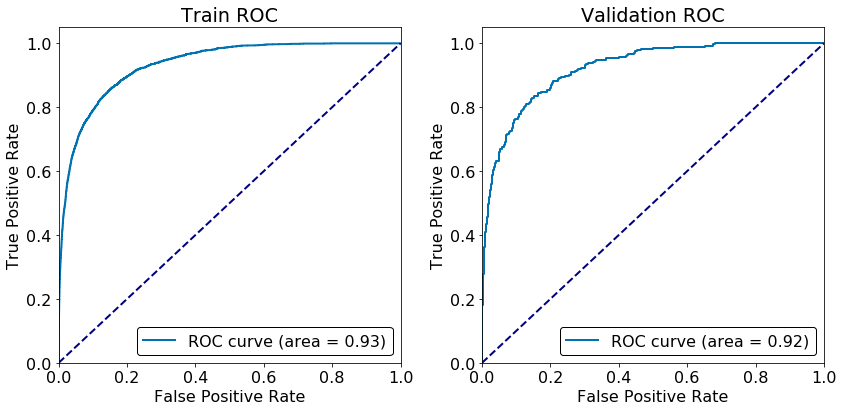

In [12]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 

plt.figure(figsize=(12, 6))

plt.subplot(121)

fpr, tpr, _ = roc_curve(y, oof)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

plt.subplot(122)

fpr, tpr, _ = roc_curve(yval, ypred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [13]:
val_acc = accuracy_score(yval, np.round(ypred))
print("validation accuracy: {:.3f}".format(val_acc))

validation accuracy: 0.937


In [14]:
Xval = np.array(XGB_data.values[:, :-1], np.float32) 
yval = np.array(XGB_data['targets'].values, np.float32)

tn, fp, fn, tp = confusion_matrix(yval, np.round(Xval[:, -1])).ravel()

accuracy = (tp + tn) / len(yval)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

print("CNN Stats:")

print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(yval, np.round(Xval[:, -1])))

tn, fp, fn, tp = confusion_matrix(yval, np.round(ypred)).ravel()

accuracy = (tp + tn) / len(yval)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

print("\nXGBoost Stats:")

print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(yval, np.round(ypred)))

tn, fp, fn, tp = confusion_matrix(yval, np.round(Xval[:, -1]*(2/4) + ypred*(2/4))).ravel()

accuracy = (tp + tn) / len(yval)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

CNN Stats:
Model accuracy: 0.84
Model precision: 0.34
Model recall: 0.81

Confusion Matrix: 
[[2310  441]
 [  51  223]]

XGBoost Stats:
Model accuracy: 0.94
Model precision: 0.76
Model recall: 0.45

Confusion Matrix: 
[[2712   39]
 [ 151  123]]


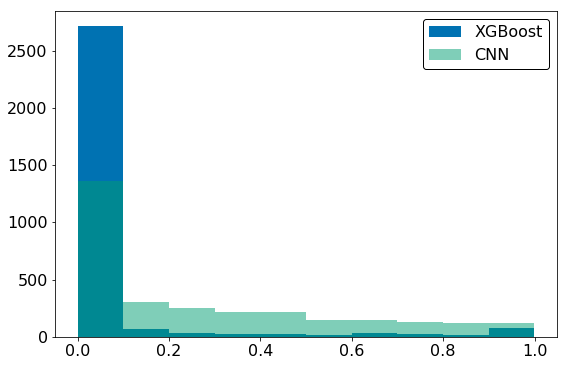

In [15]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.hist(ypred, label='XGBoost')
plt.hist(Xval[:, -1], label='CNN', alpha=.5)
plt.legend()
plt.show()

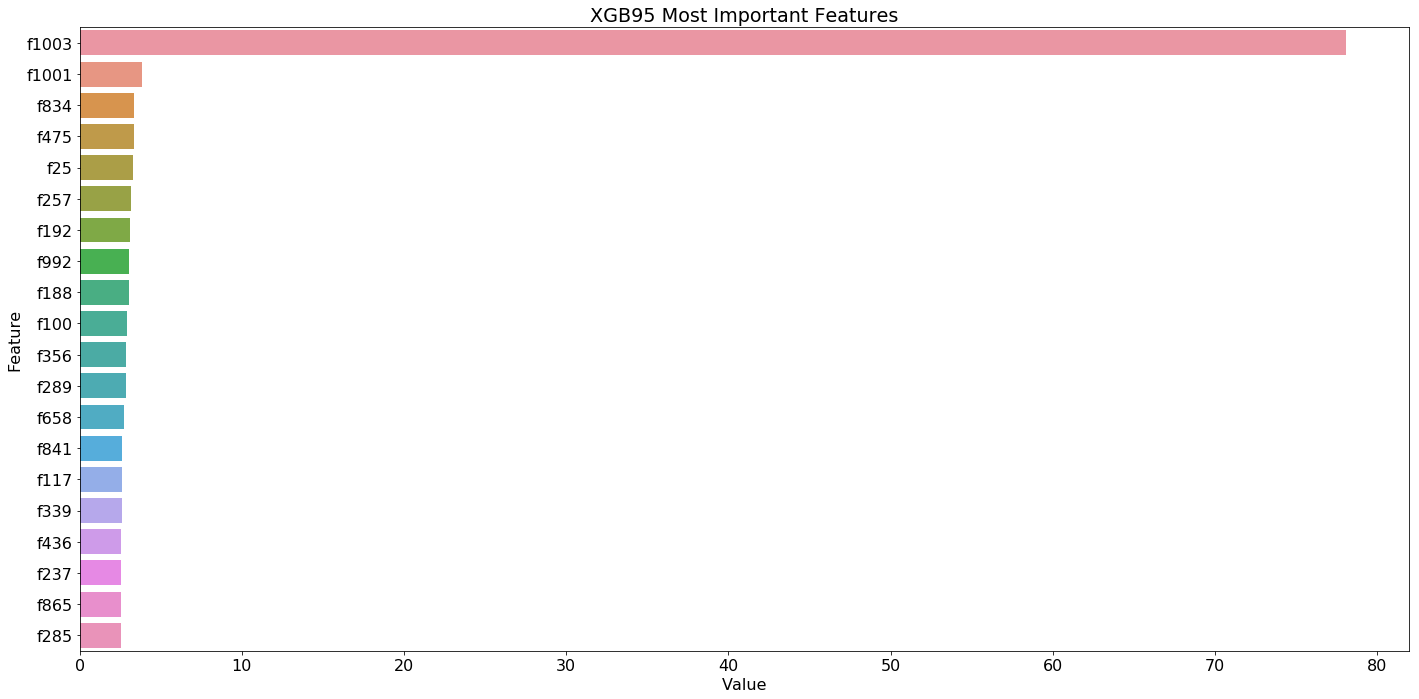

In [16]:
import seaborn as sns

bst_feature_dict = bst.get_score(importance_type='gain')
feature_names = list(bst_feature_dict.keys())
feature_importance = [bst_feature_dict[key] for key in feature_names]
feature_imp = pd.DataFrame()
feature_imp['Feature'] = feature_names 
feature_imp['Value'] = feature_importance

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

In [17]:
# Next try "test time augmentation" 
'''
# 
transform_TTA = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


class TTADataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_TTA(img)
        
        # 3. get meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

N_TTA = 5
batch_size = 1
valid_dataset = TTADataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

ypred_TTA = np.zeros((len(ypred), N_TTA))

model = model.eval()
for j in range(N_TTA):
    for i, (images, meta_data, labels) in enumerate(tqdm(valid_loader)):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model.output(embed).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)

        ypred_TTA[i, j] = bst.predict(xgb.DMatrix(batch_features))
ypred_TTA_mean = np.mean(ypred_TTA, 1)
'''

'\n# \ntransform_TTA = transforms.Compose([\n    transforms.RandomRotation(degrees=5),\n    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),\n    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),\n    transforms.RandomVerticalFlip(),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])\n])\n\n\nclass TTADataset(torch.utils.data.Dataset):\n    def __init__(self, df, path_to_files):\n        # 1. Initialize file paths or a list of file names.\n        self.path = path_to_files\n        self.df = df\n\n    def __getitem__(self, index):\n        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).\n        \n        # load X \n        img_name = self.df[\'image_id\'].values[index]\n        img_path = self.path + img_name + ".jpg"\n        img = plt.imread(img_path)\n        \n        # determine meta data \n        meta = self.df[meta_fe